In [18]:
import os
import sys
import mediapy as media
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


NUM_OF_GRAY_LEVELS = 256
ALL_GREYSCALE_HISTOGRAM_BINS = np.arange(NUM_OF_GRAY_LEVELS + 1)
GREYSCALE_HISTOGRAM_BINS_VALUES = np.arange(NUM_OF_GRAY_LEVELS)


# Skeleton function - DO NOT CHANGE SIGNATURE!!!
def main(video_path, video_type):
    """
    Main entry point for ex1
    :param video_path: path to video file
    :param video_type: category of the video (either 1 or 2)
    :return: a tuple of integers representing the frame number for which the scene cut was detected (i.e. the last frame index of the first scene and the first frame index of the second scene)
    """
    if video_type == 1:
        return process_video_type_1(video_path)
    elif video_type == 2:
        return process_video_type_2(video_path)
    else:
        raise ValueError("Invalid video type")


def internal_main():
    """
    Internal main entry point for the program.
    """
    try:
        # Check if arguments are provided from the terminal
        if len(sys.argv) != 3:
            print("Usage: python ex1.py <video_path> <video_type>")
            sys.exit(1)

        video_path = sys.argv[1]
        video_type = int(sys.argv[2])

        result = main(video_path, video_type)
        print(f"Scene cut detected between frames: {result}")
    except Exception as e:
        print(f"An error occurred: {e}")
        sys.exit(1)


def process_video_type_1(video_path):
    video = get_greyscale_video_by_file_path(video_path)
    cumsum_histogram_distance = get_video_cumsum_histogram_distance(video)
    frame_with_max_distance = np.argmax(cumsum_histogram_distance)
    return frame_with_max_distance, (frame_with_max_distance + 1)


def process_video_type_2(video_path):
    video = get_greyscale_video_by_file_path(video_path)
    values_arr = get_video_histogram_edges(video)
    quantized_video = quantize_video(video, values_arr)
    cumsum_histogram_distance = get_video_cumsum_histogram_distance(quantized_video)
    frame_with_max_distance = np.argmax(cumsum_histogram_distance)
    return frame_with_max_distance, (frame_with_max_distance + 1)


def get_video_cumsum_histogram_distance(video):
    video_histogram = get_video_histogram(video)
    video_cumsum_histogram = cumsum_along_y(video_histogram)
    cumsum_histogram_distance = sum_diff_consecutive_rows(video_cumsum_histogram)
    return cumsum_histogram_distance


def get_video_by_file_path(path: str):
    """

    :rtype: mediapy_video
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    return media.read_video(path)


def get_grayscale_video(mediapy_video) -> np.ndarray:
    num_frames, height, width, channels = mediapy_video.shape
    greyscale_video = np.empty((num_frames, height, width), dtype=np.uint8)

    for i in range(num_frames):
        greyscale_video[i] = get_greyscale_array_from_frame(mediapy_video[i])

    return greyscale_video


def get_greyscale_array_from_frame(mediapy_frame) -> np.ndarray:
    return np.array(Image.fromarray(np.array(mediapy_frame)).convert('L'))


def get_greyscale_video_by_file_path(path):
    return get_grayscale_video(get_video_by_file_path(path))


def get_frame_histogram_with_defined_bins(frame: np.ndarray, bins: np.ndarray = ALL_GREYSCALE_HISTOGRAM_BINS) -> np.ndarray:
    hist, _ = np.histogram(frame, bins=bins)
    return hist


def get_video_histogram(video) -> np.ndarray:
    num_frames, _, _ = video.shape
    video_hist = np.zeros((num_frames, NUM_OF_GRAY_LEVELS))
    for i in range(num_frames):
        video_hist[i] = get_frame_histogram_with_defined_bins(video[i])
    return video_hist


def cumsum(histogram):
    return np.cumsum(histogram)


def cumsum_along_y(matrix):
    """
    Calculate the cumulative sum along the y-axis for each x in a 2D array.

    Parameters:
    - matrix (np.ndarray): Input 2D array.

    Returns:
    - cumsum_result (np.ndarray): 2D array containing cumulative sum for each x along the y-axis.
    """
    # Calculate cumulative sum along the y-axis
    cumsum_result = np.cumsum(matrix, axis=1)

    return cumsum_result


def sum_diff_consecutive_rows(matrix):
    """
    Calculate the sum of differences between consecutive rows in a 2D matrix.

    Parameters:
    - matrix (np.ndarray): Input 2D matrix.

    Returns:
    - sum_diff (np.ndarray): 1D array containing the sum of differences for each column.
    """
    # Calculate differences between consecutive rows
    signed_matrix = matrix.astype(np.int64)
    # Calculate absolute differences between consecutive rows
    abs_diff = np.abs(np.diff(signed_matrix, axis=0))
    # Sum absolute differences along the axis representing rows
    sum_abs_diff = np.sum(abs_diff, axis=1)
    return sum_abs_diff


def randomly_choose_percent(video, percent=0.05):
    percent = np.max([percent, 0.05])
    num_frames = video.shape[0]
    num_frames_to_choose = int(percent * num_frames)

    # Randomly choose 10% of the frames
    chosen_frames_indices = np.random.choice(num_frames, size=num_frames_to_choose, replace=False)

    # Create a new 3D matrix with only the chosen frames
    chosen_frames_data = video[chosen_frames_indices, :, :]

    return chosen_frames_data


def optimal_quantization(data, num_bins):
    # Reshape the 3D to a 1D array
    flattened_data = data.reshape(-1)
    matrix_2d = np.column_stack((flattened_data, np.zeros(len(flattened_data))))

    # Fit k-means clustering
    kmeans = KMeans(n_clusters=num_bins, random_state=42, n_init=10)
    kmeans.fit(matrix_2d) # np.zeros(len(flattened_data))

    # Get the cluster centers as the optimal quantization levels
    quantization_levels = kmeans.cluster_centers_

    return quantization_levels


def get_video_histogram_edges(video, num_of_bins=9) -> np.ndarray:
    video_sample = randomly_choose_percent(video)
    return optimal_quantization(video_sample, num_of_bins)


def map_to_closest_values(matrix, values):
    """
    Map each pixel value in a 2D matrix to the closest value in the given array.

    Parameters:
    - matrix (np.ndarray): Input 2D matrix of integers.
    - values (np.ndarray): Array of integers to map to.

    Returns:
    - mapped_matrix (np.ndarray): Matrix with each pixel value mapped to the closest value in the array.
    """
    # Flatten the matrix and values arrays for easier computation
    flat_matrix = matrix.flatten()
    flat_values = values.flatten()

    # Find the index of the closest value in values for each pixel in the matrix
    closest_indices = np.argmin(np.abs(flat_matrix[:, np.newaxis] - flat_values), axis=1)

    # Map each pixel value to the closest value in values
    mapped_matrix = flat_values[closest_indices].reshape(matrix.shape)

    return mapped_matrix


def quantize_video(video, values_arr):
    quantized_video = np.zeros(video.shape).astype(np.uint8)
    for i in range(video.shape[0]):
        image = map_to_closest_values(video[i], values_arr)
        quantized_video[i] = image
    return quantized_video


def plot_1d_histogram(bins, values):
    plt.bar(bins, values, color='green')
    plt.title('Histogram')
    plt.xlabel('Value')
    plt.ylabel('Occurrences')
    plt.grid(True)
    plt.show()


def plot_2d_histogram(mat: np.ndarray, title='Histogram', xlabel='Frame', ylabel='Grayscale'):
    hist_to_show = np.rot90(mat)
    plt.imshow(hist_to_show, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().invert_yaxis()
    plt.show()


def get_top5_max_values(arr):
    # Get the indices of the top 5 maximum values
    indices = np.argsort(arr)[-5:][::-1]
    
    # Get the top 5 maximum values
    top5_values = arr[indices]
    
    return top5_values, indices


In [5]:
video_path = './assets/video4_category2.mp4'
video = get_greyscale_video_by_file_path(video_path)


In [20]:
def analyze_video_histogram(video):
    num_iterations = 20  # 1 unquantized + 13 quantized
    results = np.zeros((num_iterations, 5, 3))

    # Calculate unquantized video-related values
    video_histogram_unquantized = get_video_cumsum_histogram_distance(video)
    frames_with_max_distance_unquantized, indices_unquantized = get_top5_max_values(video_histogram_unquantized)

    results[0, :, 0] = indices_unquantized
    results[0, :, 1:] = frames_with_max_distance_unquantized[:, np.newaxis]


    for i in range(7, 20):
        # Quantized video
        values_arr = get_video_histogram_edges(video, num_of_bins=i)
        quantized_video = quantize_video(video, values_arr)
        cumsum_histogram_distance = get_video_cumsum_histogram_distance(quantized_video)
        frames_with_max_distance, indices = get_top5_max_values(cumsum_histogram_distance)
        # Update results array
        results[i - 1, :, 0] = indices
        results[i - 1, :, 1:] = frames_with_max_distance[:, np.newaxis]

    return results



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


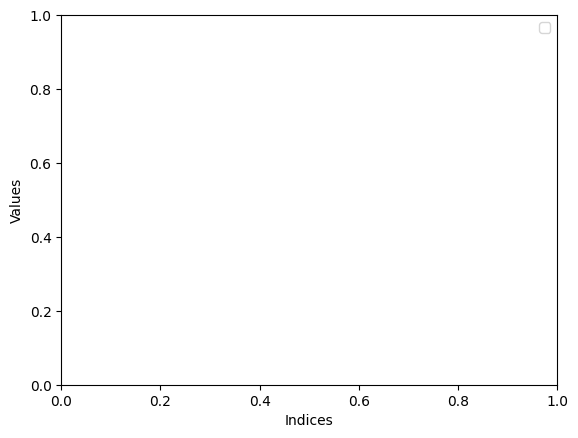

In [21]:
results = analyze_video_histogram(video)

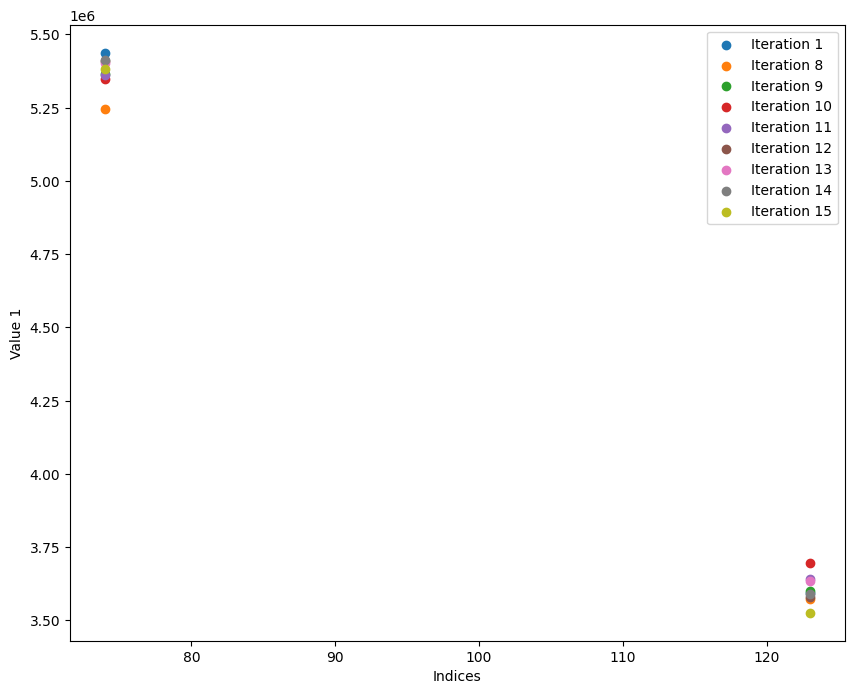

In [42]:
def plot_results(results):
    num_iterations, num_indices, _ = results.shape

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    for i in np.concatenate([[0], np.arange(7,15)]):
        indices = results[i, :2, 0]
        values1 = results[i, :2, 1]
        values2 = results[i, :2, 2]

        # Plot the distances for each index and iteration
        ax.scatter(indices, values2, label=f"Iteration {i + 1}")

    ax.set_xlabel("Indices")
    ax.set_ylabel("Value 1")
    ax.legend()

    plt.show()

# Example usage:
# Assume 'your_results' is the output of analyze_video_histogram
plot_results(results)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


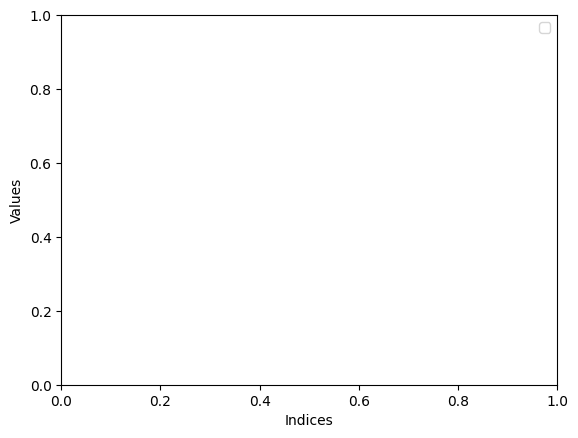

In [36]:
video3_path = './assets/video4_category2.mp4'
video3 = get_greyscale_video_by_file_path(video3_path)

In [ ]:
video3_results = analyze_video_histogram(video3)

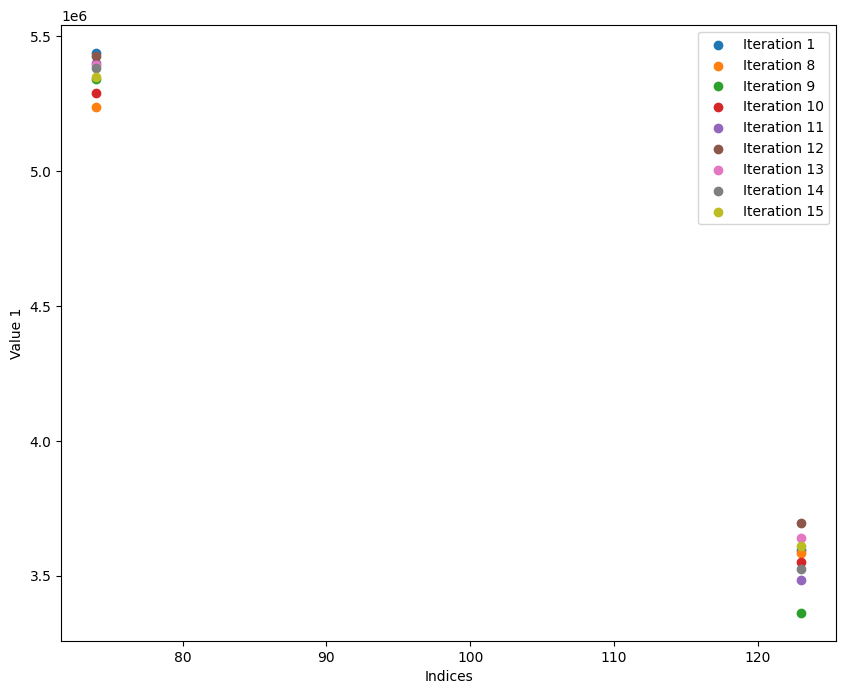

In [43]:
plot_results(video3_results)


In [52]:
def find_max_difference_index(results):
    num_iterations, num_indices, _ = results.shape

    max_difference_index = None
    max_difference = 0

    for i in range(num_iterations):
        values1 = results[i, :1, ]
        values2 = results[i, :2, ]

        current_difference = np.max(np.abs(values1 - values2))

        if current_difference > max_difference:
            max_difference = current_difference
            max_difference_index = i

    return max_difference_index


In [89]:
def compute_diff_for_each_index(results):
    num_iterations, _, _ = results.shape

    # Initialize an array to store the differences for each index
    index_diffs = np.zeros(num_iterations)

    for i in range(num_iterations):
        values1 = results[i, 0, 1]
        values2 = results[i, 1, 1]

        # Compute the differences for each index
        index_diffs[i] = np.max(np.abs(values1 - values2))

    return index_diffs

In [90]:
diffs_per_bin = compute_diff_for_each_index(results)

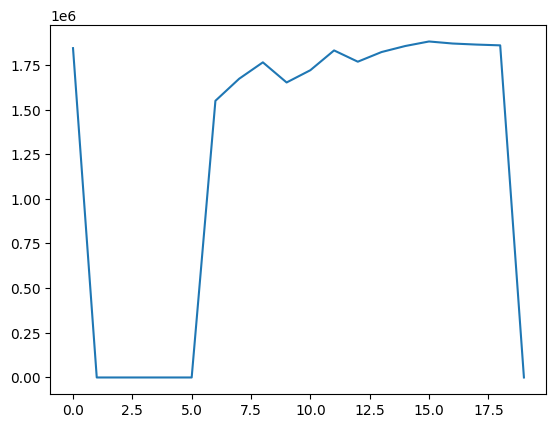

In [91]:
plt.plot(diffs_per_bin)

In [92]:
np.argmax(diffs_per_bin)

15

In [93]:
diffs_per_bin_3 = compute_diff_for_each_index(video3_results)


In [94]:
np.argmax(diffs_per_bin_3)

8

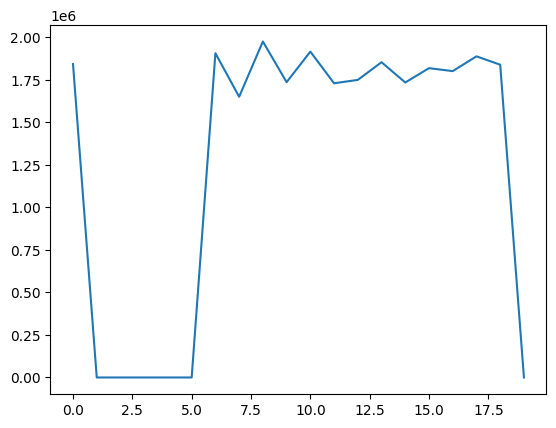

In [100]:
plt.plot(diffs_per_bin_3)
